# **Optimizing Content Strategy: A Data Analytics Approach**

## **Introduction**

In the highly competitive world of streaming services, understanding user preferences and engagement is key to attracting and retaining subscribers.

Our goal is to **analyze viewership patterns, user ratings, and engagement metrics to determine which types of content perform best and how to optimize their release strategy** through a combination of exploratory data analysis (EDA), data preprocessing, and machine learning models.

This notebook will guide you through:  
- **Data Cleaning & Preprocessing**: Handling missing values, outliers, and data transformations.
- **Exploratory Data Analysis**: Visualizing key trends and relationships in the dataset.
- **Feature Engineering**: Creating meaningful variables to improve model performance.
- **Machine Learning Modeling**: Training and evaluating predictive models.
- **Insights & Conclusions**: Interpreting results and key takeaways from the analysis.

In [58]:
# Install and import necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Load the training and testing data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [60]:
train.head()

,content_id,title,content_type,genre,sub_genre,release_year,language,country_of_origin,content_age_rating,budget,...,completion_rate,total_views,avg_watch_time,revenue,awards,critic_score,user_engagement_score,marketing_spend,licensing_cost,user_retention
0,645543,The Surreal Conspiracy,Documentary,Drama,Historical,2013,Spanish,USA,PG,6.744258e+06,...,85.792005,8067.786265,20.718243,2835.071735,7,87.991891,110.000000,2.281850e+06,1481.325232,4.910349e+19
1,939316,Astro Saga in the Cosmos,Documentary,Drama,Crime,2023,Japanese,USA,PG,6.178134e+06,...,80.437724,750.473993,24.262058,655.016451,4,91.867209,85.750069,1.601333e+06,195.900521,NaN
2,280014,Synthesizing the Eternal Artifact,Movie,Action,Satire,2000,Japanese,USA,PG,1.588919e+07,...,82.882434,77701.229657,10.776592,19516.690216,3,66.761330,90.000000,5.274652e+06,15457.226653,4.901917e+23
3,215181,The Artifact of Savage Zenith,Movie,Romance,Satire,2019,English,UK,G,NaN,...,80.022574,4411.172846,11.376984,2701.183619,4,58.300367,113.564852,1.815005e+07,921.621615,1.672483e+15
4,241683,Resonating the Spectral Prophecy,Movie,Drama,Historical,1993,Spanish,USA,PG-13,1.518643e+07,...,72.209335,11678.765250,6.219910,16938.114373,1,47.234645,64.426039,4.809484e+06,15134.227463,2.539603e+08


## **Data Exploration and Preparation**

It is essential to ensure the data is ready for accurate and reliable results. We shall explore dataset thoroughly, and look for any potential issues that could affect our findings.

This data exploration and preparation stage is crucial before proceeding with any further analysis. The insights we gain and the cleaning processes we implement here will significantly impact the validity of our subsequent findings.

We shall first focus on data cleaning, which entails:
- Filling in missing values
- Smoothening noisy data
- Identifying and removing outliers

In [61]:
# Identify columns with missing values
missing_values = train.isnull().sum()

# Filter to only show columns with missing values
missing_values = missing_values[missing_values > 0]
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
budget                   40075
imdb_rating              39934
revenue                  40081
critic_score             39642
user_engagement_score    40164
user_retention           39921
dtype: int64


From this, we can find out the following columns have missing values:
- user_engaegement_score
- revenue
- budget
- imdb_rating
- user_retention
- critic_score

We can compute the median for each column, and using that to fill in the missing values.

Columns like **revenue** and **budget** highly depend on other factors of the dataset, precisely content_type, genre, release_year and language. Thus, we shall consider these while computing the medians and filling the missing values.

In [62]:
# Group by 'genre' and compute median of 'revenue' and 'budget'
median_revenue = train.groupby('genre')['revenue'].median()
median_budget = train.groupby('genre')['budget'].median()

# Replace missing values with corresponding medians
train = train.merge(median_revenue.reset_index().rename(columns={'revenue': 'median_revenue'}), 
                   on='genre', how='left')
train = train.merge(median_budget.reset_index().rename(columns={'budget': 'median_budget'}), 
                   on='genre', how='left')

# Fill missing values using coalesce logic
train['revenue'] = train['revenue'].fillna(train['median_revenue'])
train['budget'] = train['budget'].fillna(train['median_budget'])

# Drop the temporary median columns
train = train.drop(['median_revenue', 'median_budget'], axis=1)

# For remaining columns with missing values, use simple median imputation
missing_cols = train.columns[train.isnull().any()].tolist()
other_cols = [col for col in missing_cols if col not in ['revenue', 'budget']]

for col in other_cols:
    train[col] = train[col].fillna(train[col].median())

In [63]:
# Check if there are any remaining missing values
missing_values = train.isnull().sum()

# Filter to only show columns with missing values
missing_values = missing_values[missing_values > 0]
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
Series([], dtype: int64)


In [64]:
# Identify categorical and numeric columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:")
print(categorical_cols)
print("\nNumeric columns:")
print(numeric_cols)

Categorical columns:
['title', 'content_type', 'genre', 'sub_genre', 'language', 'country_of_origin', 'content_age_rating']

Numeric columns:
['content_id', 'release_year', 'budget', 'runtime', 'imdb_rating', 'streamly_rating', 'completion_rate', 'total_views', 'avg_watch_time', 'revenue', 'awards', 'critic_score', 'user_engagement_score', 'marketing_spend', 'licensing_cost', 'user_retention']


Note that there are catergorical columns such as 'content_type' and 'genre' in the data. To make sure these are part of the analysis, we shall encode them with suitable integers, using the Label Encoding method.

In [65]:
# Encode categorical columns using LabelEncoder
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(df, categorical_cols):
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

train = encode_categorical_columns(train, categorical_cols)

We can notice that the 'user_retention' is not refined compared to the other columns of the data. To make sure that it is, we can scale the values down such that they are in the range of 0-100

In [66]:
# Transform user_retention using log1p to handle skewness 
train['user_retention'] = np.log1p(train['user_retention'])

In [67]:
# Final data
train.head()

,content_id,title,content_type,genre,sub_genre,release_year,language,country_of_origin,content_age_rating,budget,...,completion_rate,total_views,avg_watch_time,revenue,awards,critic_score,user_engagement_score,marketing_spend,licensing_cost,user_retention
0,645543,666114,0,2,3,2013,6,6,1,6.744258e+06,...,85.792005,8067.786265,20.718243,2835.071735,7,87.991891,110.000000,2.281850e+06,1481.325232,45.340462
1,939316,19839,0,2,1,2023,4,6,1,6.178134e+06,...,80.437724,750.473993,24.262058,655.016451,4,91.867209,85.750069,1.601333e+06,195.900521,25.510594
2,280014,364178,1,0,5,2000,4,6,1,1.588919e+07,...,82.882434,77701.229657,10.776592,19516.690216,3,66.761330,90.000000,5.274652e+06,15457.226653,54.549083
3,215181,396262,1,3,5,2019,0,5,0,5.534109e+06,...,80.022574,4411.172846,11.376984,2701.183619,4,58.300367,113.564852,1.815005e+07,921.621615,35.053086
4,241683,312205,1,2,3,1993,6,6,2,1.518643e+07,...,72.209335,11678.765250,6.219910,16938.114373,1,47.234645,64.426039,4.809484e+06,15134.227463,19.352688


## **Analyzing Movie Success Factors and Performance Metrics**

Our next step is to analyze the success factors of movies and their performance metrics. We are particularly interested in how various variables in our dataset relate to each other. For this analysis, we will use a correlation plot to visualize the relationships between the relevant variables.

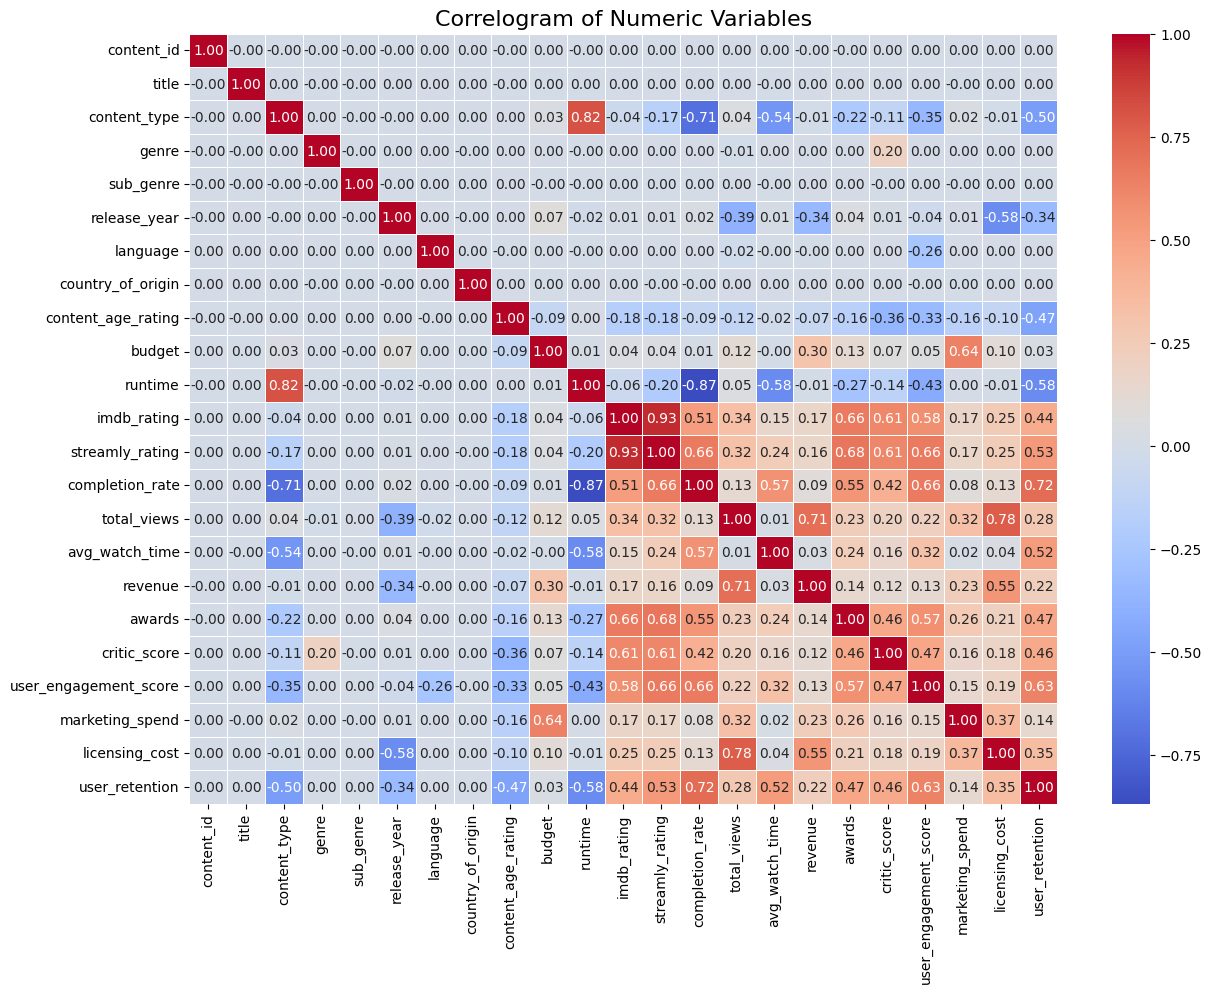

In [68]:
# Select only numeric columns for correlation analysis
numeric_data = train.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlogram of Numeric Variables', fontsize=16)
plt.show()

From the correlogram, we can find out that there are strong relationships between some variables.
Some strong positive and negative correlations are:

- **'streamly_rating' & 'imdb_rating'** - This indicates that they are highly positively correlated, and there is a consistent rating of the movie among the different services (Steamly and IMDb)

- **'completion rate' and 'runtime'** - The strong negative correlation indicates the inproportionality in them. If a movie has a long runtime, the audience does not tend to complete it in time.

- **'revenue' & 'total_views'** - Self explanatory. More views lead to more revenue.

- **'total_views' & 'licensing_cost'** and **'revenue' & 'licensing_cost'**

- **'content_type'** & ***'runtime'*** and ***'completion_rate'*** - Movies and documentaries will naturally have a lesser runtime than TV-Series, thus proving a stron correlation.

We can add more metrics based on these relationships to provide more depth to our dataset.

1. Total Rating - Provides unified measure of content quality across different rating systems
2. Engagement Completion Interaction - Measures how well content keeps viewers both engaged and watching till the end
3. Average watchtime per completion - Indicates typical viewing duration for users who finish the content
4. Revenue per view - Shows average monetary value generated per viewing session


In [69]:
# Add more metrics and refine the train & test data
train['roi'] = np.where(train['budget'] > 0, train['revenue'] / train['budget'], np.nan)
train['total_rating'] = np.nanmean([train['streamly_rating'] * 2, train['imdb_rating'], train['critic_score'] / 10], axis=0)
train['engagement_completion_interaction'] = train['user_engagement_score'] * train['completion_rate'] 
train['avg_watch_time_per_completion'] = train['avg_watch_time'] / train['completion_rate']
train['revenue_per_view'] = train['revenue'] / train['total_views']

test['roi'] = np.where(test['budget'] > 0, test['revenue'] / test['budget'], np.nan)
test['total_rating'] = np.nanmean([test['streamly_rating'] * 2, test['imdb_rating'], test['critic_score'] / 10], axis=0)
test['engagement_completion_interaction'] = test['user_engagement_score'] * test['completion_rate']
test['avg_watch_time_per_completion'] = test['avg_watch_time'] / test['completion_rate']
test['revenue_per_view'] = test['revenue'] / test['total_views']

print(train.describe())

          content_id          title   content_type          genre  \
count  800000.000000  800000.000000  800000.000000  800000.000000   
mean   499920.894689  399999.500000       1.199858       2.500929   
std    288691.692185  230940.252013       0.599650       1.706882   
min         1.000000       0.000000       0.000000       0.000000   
25%    249976.500000  199999.750000       1.000000       1.000000   
50%    499782.500000  399999.500000       1.000000       3.000000   
75%    750070.250000  599999.250000       2.000000       4.000000   
max    999999.000000  799999.000000       2.000000       5.000000   

           sub_genre   release_year       language  country_of_origin  \
count  800000.000000  800000.000000  800000.000000      800000.000000   
mean        2.498981    2006.480849       2.324539           3.800711   
std         1.709166       9.809090       2.408979           2.087954   
min         0.000000    1990.000000       0.000000           0.000000   
25%         1

Since our goal is to analyze viewing patterns and engagement metrics, our main focus shall be on **'user_retention'**, and we shall make nesseccary observations and predictions based on it.

By assessing the correlation matrix, we can observe that a bunch of variables have a strong to decent correlation with the 'user_retention'

- **completion_rate** - This makes sense as a movie that tends to get completed often, will automatically have a high user retention.
- **user_engagement_score** - A high engagement score will lead to users sticking to the movie more.
- **runtime** - We observe a negative correaltion. This could mean that there is a high user retention to shorter content.
- **content_type** - Users tend to watch more movies and documentaries, compared to TV shows, as they have a longer runtime.

To improve user retention, we can:
- Enhance user engagement, by creating and pushing more Interactive content, enable community features such as comments, live forums, etc., and provide personalized recommendations.
- Promote short-form content, as shorter runtime holds more retention.
- Increase average watch time, by creating binge-worthy content.

## **User Retention Analysis and Modeling**

Our ultimate goal is to develop a model that predicts user retention for movies. We need to develop a model to predict user retention based on content characteristics and performance metrics, and analyze how each feature used in the model affects user retention.

By analyzing how each feature affects user retention, we can gain valuable insights into the factors that drive or hinder viewer engagement. Understanding the impact of these features allows us to refine your model for better accuracy.

In [70]:
# Prepare data for modeling
X = train.drop(['user_retention'], axis=1)
y = train['user_retention']

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get model statistics
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

## **Model Evaluation**

To ensure the reliability of the regression model, we shall select appropriate evaluation metrics to assess the model's performance.
Calculate and interpret the chosen evaluation metrics.

In [71]:
# Print metrics
print(f"R-squared value: {r2_score(y, y_pred):.3f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y, y_pred):.3f}")

R-squared value: 0.833
Mean Squared Error (MSE): 39.639


The linear regression model assesses the relationship between various features and user_retention.
Here are the appropriate evaluation metrics and their interpretations:
- **R-squared value** (0.8331) indicates that approximately 83.31% of the variance in user_retention is explained by the model. This shows that the model captures a significant portion of the variability.
- **Mean Squared Error (MSE)** gives the average squared difference between predicted and observed values, which penalizes larger errors more than Mean Absolute Error. RMSE is the square root of MSE and provides error in the same units as the dependent variable, making it easier to interpret.

These metrics are appropriate enough to assess the quality of this model. Although this does not give us a complete picture of the solution, it is a great way to predict user retentions of various test datas. We can always use other metrics and consider more relations between columns, to improved the model and get better results.

## Implement Model on Test Data

We can now proceed to implement and make predicitions of user retention on our test data

In [72]:
# Prepare test data
X_test = test.drop(['title'], axis=1)
X_test = encode_categorical_columns(test, categorical_cols)

# Predict user retention on the test data
test_predictions = model.predict(X_test)

# Create output dataframe
output_data = pd.DataFrame({
    'title': test['title'],
    'user_retention': test_predictions
})

# Save predictions to a CSV file
output_data.to_csv('output_data.csv', index=False)

output_data.head(10)

,title,user_retention
0,53856,39.508199
1,992,40.683515
2,103887,40.747749
3,54560,14.318187
4,124995,34.042455
5,27220,25.919135
6,42243,22.681597
7,138120,33.962556
8,109541,24.644863
9,53308,16.100979
